In [7]:
from pymongo import MongoClient
import numpy as np
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity

In [8]:
def load_data_from_mongodb(uri, db_name, collection_name):
    client = MongoClient(uri)
    db = client[db_name]
    collection = db[collection_name]
    documents = list(collection.find({}, {"_id": 0}))
    return documents

def ensure_string(value):
    if isinstance(value, list):
        return " ".join(value)
    return str(value)

def normalize_genres(genres):
    if isinstance(genres, list):
        return [g.strip().lower() for g in genres if g.strip()]
    elif isinstance(genres, str) and genres.strip():
        return [genres.strip().lower()]
    else:
        return ["unknown"]

def get_song_vector(song_lyrics, model):
    song_lyrics = ensure_string(song_lyrics)
    words = song_lyrics.lower().split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(model.vector_size)

def get_genre_onehot_vector(genres, genre_list):
    genre_tags = normalize_genres(genres)
    onehot = np.zeros(len(genre_list))
    for genre in genre_tags:
        if genre in genre_list:
            index = genre_list.index(genre)
            onehot[index] = 1
    return onehot

def get_combined_song_vector(doc, model, genre_list):
    lyrics_vec = get_song_vector(doc.get("lyrics", ""), model)
    genre_vec = get_genre_onehot_vector(doc.get("genres", "unknown"), genre_list)

    title = doc.get("title", "Unknown")
    print(f"\n[벡터 생성] '{title}'")
    print(f" - 가사 벡터 (lyrics_vec): {lyrics_vec[:10]} ... (길이: {len(lyrics_vec)})")
    print(f" - 장르 원핫 벡터 (genre_vec): {genre_vec.tolist()} (길이: {len(genre_vec)})")

    combined_vec = np.concatenate([lyrics_vec, genre_vec])
    print(f" - 결합 벡터 (combined_vec): {combined_vec[:10]} ... (전체 길이: {len(combined_vec)})")

    return combined_vec

In [9]:
def recommend_similar_songs(song_title, music_data, model, song_vectors, genre_list,
                            weight_lyrics=1.0, weight_genre=1.0, top_n=5):
    if song_title not in song_vectors:
        raise ValueError(f"곡 제목 '{song_title}'에 대한 벡터가 없습니다.")

    vec_len = model.vector_size
    genre_len = len(genre_list)

    weight_vector = np.concatenate([
        np.full(vec_len, weight_lyrics),
        np.full(genre_len, weight_genre)
    ])

    target_vec = song_vectors[song_title] * weight_vector
    target_vec = target_vec.reshape(1, -1)

    print(f"\n[추천 기준 곡] '{song_title}' 벡터 길이: {target_vec.shape[1]}")

    similarities = []
    for doc in music_data:
        title = doc["title"]
        if title == song_title or title not in song_vectors:
            continue
        compare_vec = song_vectors[title] * weight_vector
        sim = cosine_similarity(target_vec, compare_vec.reshape(1, -1))[0][0]

        print(f"\n[코사인 유사도 계산] '{song_title}' vs '{title}'")
        print(f" - 비교 벡터 일부: {compare_vec[:5]}")
        print(f" - 유사도: {sim:.4f}")

        similarities.append({
            "title": title,
            "genres": ", ".join(normalize_genres(doc.get("genres", "unknown"))),
            "feature_similarities": sim
        })

    return sorted(similarities, key=lambda x: x["feature_similarities"], reverse=True)[:top_n]

In [10]:
uri = "mongodb://localhost:27017/"
db_name = "music"
collection_name = "music"
music_data = load_data_from_mongodb(uri, db_name, collection_name)
print(f"불러온 곡 개수: {len(music_data)}")

sentences = [
    ensure_string(doc.get("lyrics", "")).lower().split()
    for doc in music_data
    if "lyrics" in doc and ensure_string(doc.get("lyrics", "")).strip()
]
print(f"Word2Vec 학습 문장 수: {len(sentences)}")

if not sentences:
    raise ValueError("Word2Vec 학습을 위한 가사 문장이 없습니다. MongoDB 데이터를 확인하세요.")

word2vec_model = Word2Vec(sentences=sentences, vector_size=100, window=5, min_count=1, workers=4)

all_genres = sorted(list({g for doc in music_data for g in normalize_genres(doc.get("genres", "Unknown"))}))
print(f"총 장르 수: {len(all_genres)}")

song_vectors = {
    doc["title"]: get_combined_song_vector(doc, word2vec_model, all_genres)
    for doc in music_data
}

song_to_recommend = "입춘"

original_lyrics = next(
    (ensure_string(doc.get("lyrics", "가사 정보 없음")) for doc in music_data if doc["title"] == song_to_recommend),
    "가사 정보 없음"
)

print(f"\n'{song_to_recommend}'의 원본 가사 (일부):\n")
print(original_lyrics[:500] + "\n")

recommendations = recommend_similar_songs(
    song_to_recommend,
    music_data,
    word2vec_model,
    song_vectors,
    all_genres,
    weight_lyrics=0.8,
    weight_genre=0.2,
    top_n=5
)


불러온 곡 개수: 15
Word2Vec 학습 문장 수: 15
총 장르 수: 10

[벡터 생성] '서른 즈음에'
 - 가사 벡터 (lyrics_vec): [-2.6548591e-03  1.1825248e-03  1.0530573e-03  6.0380797e-04
  1.0502416e-04 -3.2395337e-04  5.8574299e-04  1.0544211e-03
  3.7836253e-05  4.5057034e-04] ... (길이: 100)
 - 장르 원핫 벡터 (genre_vec): [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0] (길이: 10)
 - 결합 벡터 (combined_vec): [-2.65485910e-03  1.18252484e-03  1.05305726e-03  6.03807974e-04
  1.05024163e-04 -3.23953369e-04  5.85742993e-04  1.05442107e-03
  3.78362529e-05  4.50570340e-04] ... (전체 길이: 110)

[벡터 생성] '사랑했지만'
 - 가사 벡터 (lyrics_vec): [ 6.1634059e-06 -6.1436847e-05 -2.9948903e-03 -6.2341581e-04
  3.7731975e-04  8.3611481e-04 -1.2701965e-03  1.4629468e-03
 -1.5167029e-03  1.8840897e-03] ... (길이: 100)
 - 장르 원핫 벡터 (genre_vec): [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0] (길이: 10)
 - 결합 벡터 (combined_vec): [ 6.16340594e-06 -6.14368473e-05 -2.99489032e-03 -6.23415806e-04
  3.77319753e-04  8.36114807e-04 -1.27019652e-03  1.46294676e-03
 -1.516

for rec in recommendations:
    print(f"\n추천: {rec['title']} (Genres: {rec['genres']})")
    print(f"  - 유사도: {rec['feature_similarities']:.4f}")

In [8]:
from pymongo import MongoClient
import numpy as np
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity

def load_data_from_mongodb(uri, db_name, collection_name):
    client = MongoClient(uri)
    db = client[db_name]
    collection = db[collection_name]
    documents = list(collection.find({}, {"_id": 0}))
    return documents

def ensure_string(value):
    if isinstance(value, list):
        return " ".join(value)
    return str(value)

def normalize_genres(genres):
    if isinstance(genres, list):
        return [g.strip().lower() for g in genres if g.strip()]
    elif isinstance(genres, str) and genres.strip():
        return [genres.strip().lower()]
    else:
        return ["unknown"]

def get_song_vector(song_lyrics, model):
    song_lyrics = ensure_string(song_lyrics)
    words = song_lyrics.lower().split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(model.vector_size)

def get_genre_onehot_vector(genres, genre_list):
    genre_tags = normalize_genres(genres)
    onehot = np.zeros(len(genre_list))
    for genre in genre_tags:
        if genre in genre_list:
            index = genre_list.index(genre)
            onehot[index] = 1
    return onehot

def get_combined_song_vector(doc, model, genre_list):
    lyrics_vec = get_song_vector(doc.get("lyrics", ""), model)
    genre_vec = get_genre_onehot_vector(doc.get("genres", "unknown"), genre_list)

    title = doc.get("title", "Unknown")
    print(f"\n[벡터 생성] '{title}'")
    print(f" - 가사 벡터 (lyrics_vec): {lyrics_vec[:10]} ... (길이: {len(lyrics_vec)})")
    print(f" - 장르 원핫 벡터 (genre_vec): {genre_vec.tolist()} (길이: {len(genre_vec)})")

    combined_vec = np.concatenate([lyrics_vec, genre_vec])
    print(f" - 결합 벡터 (combined_vec): {combined_vec[:10]} ... (전체 길이: {len(combined_vec)})")

    return combined_vec

def recommend_similar_songs(song_title, music_data, model, song_vectors, genre_list,
                            weight_lyrics=1.0, weight_genre=1.0, top_n=5):
    if song_title not in song_vectors:
        raise ValueError(f"곡 제목 '{song_title}'에 대한 벡터가 없습니다.")

    vec_len = model.vector_size
    genre_len = len(genre_list)

    weight_vector = np.concatenate([
        np.full(vec_len, weight_lyrics),
        np.full(genre_len, weight_genre)
    ])

    target_vec = song_vectors[song_title] * weight_vector
    print(f"\n[추천 기준 곡] '{song_title}' 벡터 길이: {target_vec.shape[0]}")

    similarities = []
    for doc in music_data:
        title = doc["title"]
        if title == song_title or title not in song_vectors:
            continue
        compare_vec = song_vectors[title] * weight_vector
        sim = cosine_similarity([target_vec], [compare_vec])[0][0]

        print(f"\n[코사인 유사도 계산] '{song_title}' vs '{title}'")
        print(f" - 비교 벡터 일부: {compare_vec[:5]}")
        print(f" - 유사도: {sim:.4f}")

        similarities.append({
            "title": title,
            "genres": ", ".join(normalize_genres(doc.get("genres", "unknown"))),
            "feature_similarities": sim
        })

    return sorted(similarities, key=lambda x: x["feature_similarities"], reverse=True)[:top_n]

# ------------------------- 실행 파트 -------------------------

uri = "mongodb://localhost:27017/"
db_name = "music"
collection_name = "music"
music_data = load_data_from_mongodb(uri, db_name, collection_name)
print(f"불러온 곡 개수: {len(music_data)}")

sentences = []
for doc in music_data:
    lyrics = ensure_string(doc.get("lyrics", ""))
    if lyrics.strip():
        sentences.append(lyrics.lower().split())

if not sentences:
    raise ValueError("Word2Vec 학습을 위한 가사 문장이 없습니다. MongoDB 데이터를 확인하세요.")

word2vec_model = Word2Vec(sentences=sentences, vector_size=100, window=5, min_count=1, workers=4) #

all_genres = sorted(list({g for doc in music_data for g in normalize_genres(doc.get("genres", "unknown"))}))
print(f"총 장르 수: {len(all_genres)}")

song_vectors = {
    doc["title"]: get_combined_song_vector(doc, word2vec_model, all_genres)
    for doc in music_data
}

song_to_recommend = "서른 즈음에"

lyrics_text = next(
    (ensure_string(doc.get("lyrics", "")) for doc in music_data if doc["title"] == song_to_recommend),
    "가사 정보 없음"
)
print(f"\n'{song_to_recommend}'의 원본 가사 (일부):\n")
print(lyrics_text[:500] + "\n")

recommendations = recommend_similar_songs(
    song_to_recommend,
    music_data,
    word2vec_model,
    song_vectors,
    all_genres,
    weight_lyrics=0.75,
    weight_genre=0.25,
    top_n=5
)

for rec in recommendations:
    print(f"\n추천: {rec['title']} (Genres: {rec['genres']})")
    print(f"  - 유사도: {rec['feature_similarities']:.4f}")


불러온 곡 개수: 15
총 장르 수: 10

[벡터 생성] '서른 즈음에'
 - 가사 벡터 (lyrics_vec): [-2.6548591e-03  1.1825248e-03  1.0530573e-03  6.0380797e-04
  1.0502416e-04 -3.2395337e-04  5.8574299e-04  1.0544211e-03
  3.7836253e-05  4.5057034e-04] ... (길이: 100)
 - 장르 원핫 벡터 (genre_vec): [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0] (길이: 10)
 - 결합 벡터 (combined_vec): [-2.65485910e-03  1.18252484e-03  1.05305726e-03  6.03807974e-04
  1.05024163e-04 -3.23953369e-04  5.85742993e-04  1.05442107e-03
  3.78362529e-05  4.50570340e-04] ... (전체 길이: 110)

[벡터 생성] '사랑했지만'
 - 가사 벡터 (lyrics_vec): [ 6.1634059e-06 -6.1436847e-05 -2.9948903e-03 -6.2341581e-04
  3.7731975e-04  8.3611481e-04 -1.2701965e-03  1.4629468e-03
 -1.5167029e-03  1.8840897e-03] ... (길이: 100)
 - 장르 원핫 벡터 (genre_vec): [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0] (길이: 10)
 - 결합 벡터 (combined_vec): [ 6.16340594e-06 -6.14368473e-05 -2.99489032e-03 -6.23415806e-04
  3.77319753e-04  8.36114807e-04 -1.27019652e-03  1.46294676e-03
 -1.51670293e-03  1.88408967

In [12]:
# 학습에 사용된 단어들 중 일부를 샘플링하여 가장 유사한 단어 확인
words = list(word2vec_model.wv.key_to_index)[:10]
for word in words:
    print(f"\n단어: {word}")
    try:
        print(word2vec_model.wv.most_similar(word, topn=5))
    except KeyError:
        print("벡터 없음")


단어: 싶어
[('싶다고', 0.3708465099334717), ('내게', 0.32382601499557495), ('내리죠', 0.2849214971065521), ('아무것도', 0.2697611451148987), ('개성', 0.2685558795928955)]

단어: 내
[('피울', 0.3611774146556854), ('최고랬어', 0.315373033285141), ('지나가고', 0.2755420207977295), ('그대로인', 0.25100192427635193), ('닫겠어', 0.235616073012352)]

단어: 수
[('뭐', 0.39844414591789246), ('뒤돌아', 0.27973178029060364), ('boi', 0.2738320231437683), ('닫아버리고', 0.2690422534942627), ('사랑노래', 0.26495835185050964)]

단어: 난
[('때려', 0.2945816218852997), ('넌', 0.2942708432674408), ('돌아봐요', 0.2779499888420105), ('싶은', 0.27753975987434387), ('아닌데', 0.2675027847290039)]

단어: 그대
[('화약처럼', 0.3200548589229584), ('미스터', 0.2734862267971039), ('잠시', 0.27343958616256714), ('i', 0.2591742277145386), ('나의', 0.2507297992706299)]

단어: 이
[('찾아오는', 0.33197855949401855), ('제발', 0.3301678001880646), ('게', 0.3194219470024109), ('라랄라', 0.3076619803905487), ('뭐', 0.30717647075653076)]

단어: 날
[("i'm", 0.3808184266090393), ('날린', 0.3161330819129944), ('다', 0.30949574

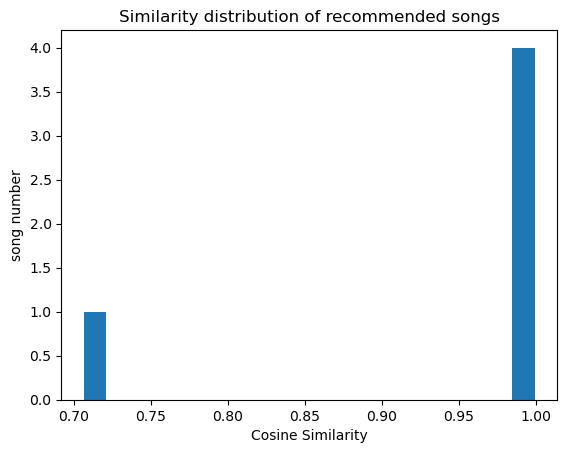

In [13]:
import matplotlib.pyplot as plt

sims = [rec["feature_similarities"] for rec in recommendations]
plt.hist(sims, bins=20)
plt.title("Similarity distribution of recommended songs")
plt.xlabel("Cosine Similarity")
plt.ylabel("song number")
plt.show()


불러온 곡 개수: 15
총 장르 수: 10)

추천: 무제 (Untitled, 2014) (Genres: k-ballad)
 - 가사 유사도: 0.3031
 - 장르 유사도: 1.0000
 - 최종 유사도: 0.6515

추천: 비밀번호 486 (Genres: k-ballad)
 - 가사 유사도: 0.2867
 - 장르 유사도: 1.0000
 - 최종 유사도: 0.6433

추천: Yeosu Night Sea(여수 밤바다) (Genres: k-ballad)
 - 가사 유사도: 0.2346
 - 장르 유사도: 1.0000
 - 최종 유사도: 0.6173

추천: 사랑했지만 (Genres: k-ballad)
 - 가사 유사도: 0.0828
 - 장르 유사도: 1.0000
 - 최종 유사도: 0.5414

추천: 우리 사랑하지 말아요 (Let's Not Fall in Love) (Genres: k-ballad, pop, k-pop)
 - 가사 유사도: 0.2156
 - 장르 유사도: 0.8577
 - 최종 유사도: 0.5366


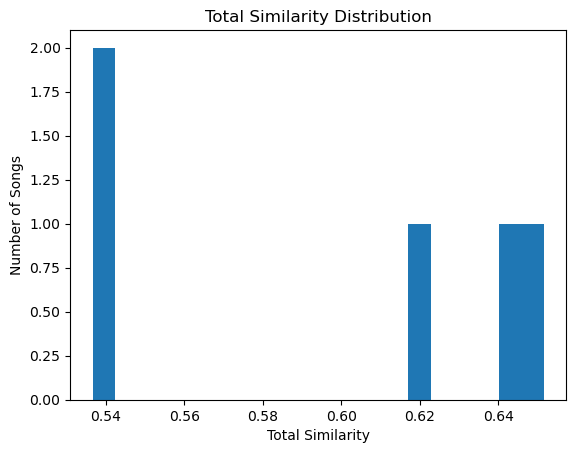

In [14]:
from pymongo import MongoClient
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity

# -----------------------------
# 데이터 로딩 관련 함수
# -----------------------------
def load_music_data(uri, db_name, collection_name):
    client = MongoClient(uri)
    db = client[db_name]
    collection = db[collection_name]
    return list(collection.find({}, {"_id": 0}))

def ensure_string(value):
    if isinstance(value, list):
        return " ".join(value)
    return str(value)

def normalize_genres(genres):
    if isinstance(genres, list):
        return [g.strip().lower() for g in genres if g.strip()]
    elif isinstance(genres, str) and genres.strip():
        return [genres.strip().lower()]
    else:
        return ["unknown"]

# -----------------------------
# Word2Vec 및 벡터화 함수
# -----------------------------
def train_word2vec_model(music_data, vector_size=100, window=5, min_count=1):
    sentences = [ensure_string(doc.get("lyrics", "")).lower().split() for doc in music_data if ensure_string(doc.get("lyrics", "")).strip()]
    if not sentences:
        raise ValueError("Word2Vec 학습을 위한 가사 문장이 없습니다.")
    return Word2Vec(sentences=sentences, vector_size=vector_size, window=window, min_count=min_count, workers=4)

def get_lyrics_vector(song_lyrics, model):
    words = ensure_string(song_lyrics).lower().split()
    vectors = [model.wv[word] for word in words if word in model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(model.vector_size)

def get_soft_genre_vector(genres, genre_list, similar_genres):
    genre_tags = normalize_genres(genres)
    soft_vector = np.zeros(len(genre_list))
    for i, target_genre in enumerate(genre_list):
        for user_genre in genre_tags:
            if user_genre == target_genre:
                soft_vector[i] = max(soft_vector[i], 0.3)
            elif target_genre in similar_genres.get(user_genre, []):
                soft_vector[i] = max(soft_vector[i], 0.1)
    return soft_vector

def build_vectors(music_data, model, genre_list, similar_genres):
    lyrics_vectors = {}
    genre_vectors = {}
    for doc in music_data:
        if "title" not in doc:
            continue
        title = doc["title"]
        lyrics_vectors[title] = get_lyrics_vector(doc.get("lyrics", ""), model)
        genre_vectors[title] = get_soft_genre_vector(doc.get("genres", "unknown"), genre_list, similar_genres)
    return lyrics_vectors, genre_vectors

# -----------------------------
# 추천 함수 (가사+장르 따로 유사도)
# -----------------------------
def recommend_similar_songs(song_title, music_data, lyrics_vectors, genre_vectors, weight_lyrics=0.5, weight_genre=0.5, top_n=5):
    if song_title not in lyrics_vectors or song_title not in genre_vectors:
        raise ValueError(f"곡 '{song_title}'에 대한 벡터가 없습니다.")

    target_lyrics_vec = lyrics_vectors[song_title].reshape(1, -1)
    target_genre_vec = genre_vectors[song_title].reshape(1, -1)

    similarities = []
    for doc in music_data:
        title = doc.get("title")
        if not title or title == song_title or title not in lyrics_vectors or title not in genre_vectors:
            continue

        lyrics_sim = cosine_similarity(target_lyrics_vec, lyrics_vectors[title].reshape(1, -1))[0][0]
        genre_sim = cosine_similarity(target_genre_vec, genre_vectors[title].reshape(1, -1))[0][0]
        total_sim = weight_lyrics * lyrics_sim + weight_genre * genre_sim

        similarities.append({
            "title": title,
            "genres": ", ".join(normalize_genres(doc.get("genres", "unknown"))),
            "lyrics_similarity": lyrics_sim,
            "genre_similarity": genre_sim,
            "total_similarity": total_sim
        })

    return sorted(similarities, key=lambda x: x["total_similarity"], reverse=True)[:top_n]

# -----------------------------
# 시각화
# -----------------------------
def plot_similarity_distribution(similarities):
    sims = [rec["total_similarity"] for rec in similarities]
    plt.hist(sims, bins=20)
    plt.title("Total Similarity Distribution")
    plt.xlabel("Total Similarity")
    plt.ylabel("Number of Songs")
    plt.show()

# -----------------------------
# 메인 실행
# -----------------------------
if __name__ == "__main__":
    uri = "mongodb://localhost:27017/"
    db_name = "music"
    collection_name = "music"

    music_data = load_music_data(uri, db_name, collection_name)
    print(f"불러온 곡 개수: {len(music_data)}")

    word2vec_model = train_word2vec_model(music_data)
    all_genres = sorted(list({g for doc in music_data for g in normalize_genres(doc.get("genres", "unknown"))}))
    print(f"총 장르 수: {len(all_genres)})")

    similar_genres = {
        "k-ballad": ["k-pop", "soundtrack", "pop"],
        "k-pop": ["k-ballad", "pop", "dance", "soundtrack"],
        "k-rock": ["indie, modern rock"],
        "soundtrack": ["k-ballad", "k-pop"],
        "k-rap": [],
        "pop": ["k-pop", "k-ballad", "dance"],
        "dance": ["pop", "electronic", "EDM"],
        "electronic": ["dance", "EDM"],
        "EDM": ["electronic", "dance"],
        "indie, modern rock": ["k-rock"],
    }

    lyrics_vectors, genre_vectors = build_vectors(music_data, word2vec_model, all_genres, similar_genres)

    song_to_recommend = "서른 즈음에"
    recommendations = recommend_similar_songs(
        song_to_recommend,
        music_data,
        lyrics_vectors,
        genre_vectors,
        weight_lyrics=0.5,
        weight_genre=0.5,
        top_n=5
    )

    for rec in recommendations:
        print(f"\n추천: {rec['title']} (Genres: {rec['genres']})")
        print(f" - 가사 유사도: {rec['lyrics_similarity']:.4f}")
        print(f" - 장르 유사도: {rec['genre_similarity']:.4f}")
        print(f" - 최종 유사도: {rec['total_similarity']:.4f}")

    plot_similarity_distribution(recommendations)


총 곡 수: 15
총 장르 수: 10

'서른 즈음에' 비슷한 추천곡:
 - 무제 (Untitled, 2014) (유사도: 0.6515)
 - 비밀번호 486 (유사도: 0.6433)
 - Yeosu Night Sea(여수 밤바다) (유사도: 0.6173)
 - 사랑했지만 (유사도: 0.5414)
 - Modern Times (유사도: 0.5266)


c:\Users\xogus\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 45432 (\N{HANGUL SYLLABLE NO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\xogus\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47000 (\N{HANGUL SYLLABLE RAE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\xogus\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\xogus\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\xogus\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52380 (\N{HANGUL SYLLABLE CEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io

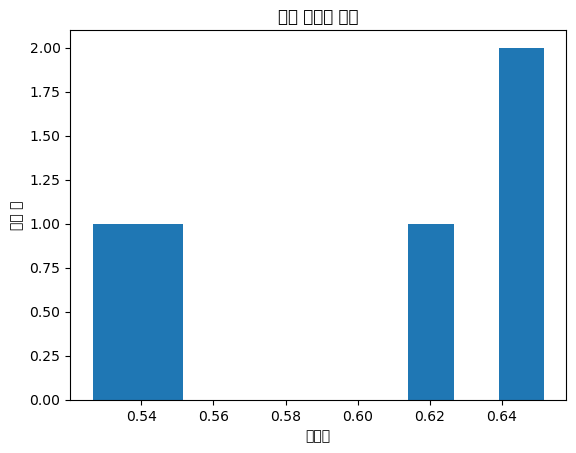

In [ ]:
from pymongo import MongoClient
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity

# -----------------------------
# 1. 데이터 불러오기
# -----------------------------
def load_music_data(uri, db_name, collection_name):
    client = MongoClient(uri)
    db = client[db_name]
    collection = db[collection_name]
    return list(collection.find({}, {"_id": 0}))

# -----------------------------
# 2. 데이터 처리 (문자열 처리)
# -----------------------------
def make_string(text):
    if type(text) == list:
        return " ".join(text)
    else:
        return str(text)

def make_genres_list(genres):
    genres_list = []
    if type(genres) == list:
        for g in genres:
            genres_list.append(g.strip().lower())
    elif type(genres) == str:
        genres_list.append(genres.strip().lower())
    else:
        genres_list.append("unknown")
    return genres_list

# -----------------------------
# 3. Word2Vec 학습
# -----------------------------
def train_word2vec(music_data, vector_size=100):
    sentences = []
    for song in music_data:
        lyrics = make_string(song.get("lyrics", "")).lower()
        words = lyrics.split()
        if len(words) > 0:
            sentences.append(words)
    
    if len(sentences) == 0:
        raise ValueError("가사 문장이 없습니다!")

    model = Word2Vec(sentences, vector_size=vector_size, window=5, min_count=1, workers=4)
    return model

# -----------------------------
# 4. 벡터 만들기
# -----------------------------
def get_lyrics_vector(lyrics, model):
    words = make_string(lyrics).lower().split()
    word_vectors = []

    for word in words:
        if word in model.wv:
            word_vectors.append(model.wv[word])

    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)
    else:
        return np.mean(word_vectors, axis=0)

def get_genre_vector(genres, all_genres):
    onehot = np.zeros(len(all_genres))
    genres_list = make_genres_list(genres)

    # 비슷한 장르 매핑 (Soft One-hot용)
    similar_genres = {
        "k-pop": ["k-ballad", "soundtrack", "pop"],
        "k-ballad": ["k-pop", "soundtrack"],
        "k-hiphop": ["k-r&b", "hip-hop"],
        "k-r&b": ["k-hiphop", "k-pop"],
        "rock": ["britpop", "pop"],
        "pop": ["k-pop", "k-ballad"],
        "soundtrack": ["k-pop", "k-ballad"],
        "hip-hop": ["lo-fi", "k-hiphop"],
        "lo-fi": ["hip-hop"],
        "indie, modern rock": ["rock"],
        "britpop": ["rock"]
    }

    for g in genres_list:
        for i, genre_name in enumerate(all_genres):
            if g == genre_name:
                onehot[i] = 0.3
            elif g in similar_genres:
                if genre_name in similar_genres[g]:
                    onehot[i] = max(onehot[i], 0.1)
    
    return onehot


def make_song_vectors(music_data, model, all_genres):
    vectors = {}
    for song in music_data:
        title = song.get("title", "")
        if title == "":
            continue
        lyrics_vec = get_lyrics_vector(song.get("lyrics", ""), model)
        genre_vec = get_genre_vector(song.get("genres", ""), all_genres)
        vectors[title] = np.concatenate([lyrics_vec, genre_vec])
    return vectors

# -----------------------------
# 5. 추천 시스템
# -----------------------------
def recommend_songs(target_title, music_data, song_vectors, top_n=5):
    if target_title not in song_vectors:
        raise ValueError(f"'{target_title}' 곡 벡터가 없습니다.")

    target_vec = song_vectors[target_title].reshape(1, -1)
    similarities = []

    for song in music_data:
        title = song.get("title", "")
        if title == "" or title == target_title:
            continue
        if title not in song_vectors:
            continue

        compare_vec = song_vectors[title].reshape(1, -1)
        sim = cosine_similarity(target_vec, compare_vec)[0][0]
        similarities.append((title, sim))

    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities[:top_n]

# -----------------------------
# 6. 시각화
# -----------------------------
def plot_similarity(similarities):
    scores = [sim for title, sim in similarities]
    plt.hist(scores, bins=10)
    plt.title("recommendation similarity distribution")
    plt.xlabel("similarity")
    plt.ylabel("number of songs")
    plt.show()

# -----------------------------
# 7. 메인 실행
# -----------------------------
if __name__ == "__main__":
    uri = "mongodb://localhost:27017/"
    db_name = "music"
    collection_name = "music"

    # 데이터 로딩
    music_data = load_music_data(uri, db_name, collection_name)
    print(f"총 곡 수: {len(music_data)}")

    # Word2Vec 학습
    model = train_word2vec(music_data)

    # 장르 리스트 만들기
    all_genres_set = set()
    for song in music_data:
        genres = make_genres_list(song.get("genres", ""))
        for g in genres:
            all_genres_set.add(g)
    all_genres = sorted(list(all_genres_set))
    print(f"총 장르 수: {len(all_genres)}")

    # 벡터 만들기
    song_vectors = make_song_vectors(music_data, model, all_genres)

    # 추천
    song_to_recommend = "서른 즈음에"
    recommendations = recommend_songs(song_to_recommend, music_data, song_vectors, top_n=5)

    # 결과 출력
    print(f"\n'{song_to_recommend}' 비슷한 추천곡:")
    for title, sim in recommendations:
        print(f" - {title} (유사도: {sim:.4f})")

    # 시각화
    plot_similarity(recommendations)


총 곡 수: 15
총 장르 수: 10

'우리 사랑하지 말아요 (Let's Not Fall in Love)' 비슷한 추천곡:
 - Modern Times (유사도: 0.7468)
 - 팔레트 (Palette) (Feat. G-DRAGON) (유사도: 0.7027)
 - 무제 (Untitled, 2014) (유사도: 0.6364)
 - Yeosu Night Sea(여수 밤바다) (유사도: 0.6014)
 - 사랑을 했다 (Love Scenario) (유사도: 0.5904)


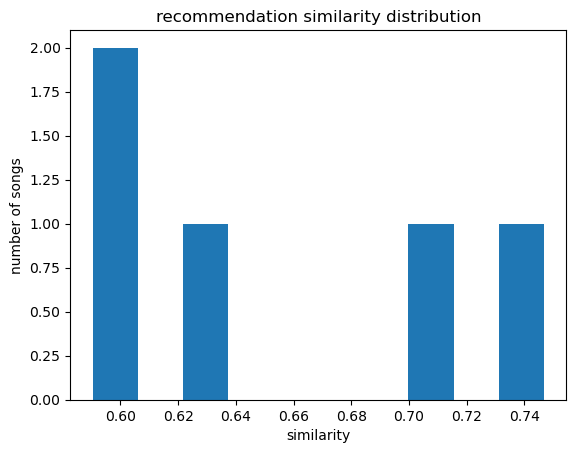

In [ ]:
from pymongo import MongoClient
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity

# -----------------------------
def load_music_data(uri, db_name, collection_name):
    client = MongoClient(uri)
    db = client[db_name]
    collection = db[collection_name]
    return list(collection.find({}, {"_id": 0}))

# -----------------------------
def make_string(text):
    return " ".join(text) if isinstance(text, list) else str(text)

def make_genres_list(genres):
    if isinstance(genres, list):
        return [g.strip().lower() for g in genres]
    elif isinstance(genres, str):
        return [genres.strip().lower()]
    else:
        return ["unknown"]

# -----------------------------
def train_word2vec(music_data, vector_size=100):
    sentences = []
    for song in music_data:
        lyrics = make_string(song.get("lyrics", "")).lower()
        words = lyrics.split()
        if words:
            sentences.append(words)

    if not sentences:
        raise ValueError("가사 문장이 없습니다!")
    
    model = Word2Vec(sentences, vector_size=vector_size, window=5, min_count=1, workers=4, epochs=5)
    return model

# -----------------------------
def get_lyrics_vector(lyrics, model):
    words = make_string(lyrics).lower().split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(model.vector_size)

def get_genre_vector(genres, all_genres):
    onehot = np.zeros(len(all_genres))
    genres_list = make_genres_list(genres)

    similar_genres = {
        "k-pop": ["k-ballad", "soundtrack", "pop"],
        "k-ballad": ["k-pop", "soundtrack"],
        "k-hiphop": ["k-r&b", "hip-hop"],
        "k-r&b": ["k-hiphop", "k-pop"],
        "rock": ["britpop", "pop"],
        "pop": ["k-pop", "k-ballad"],
        "soundtrack": ["k-pop", "k-ballad"],
        "hip-hop": ["lo-fi", "k-hiphop"],
        "lo-fi": ["hip-hop"],
        "indie, modern rock": ["rock"],
        "britpop": ["rock"]
    }

    for g in genres_list:
        for i, genre_name in enumerate(all_genres):
            if g == genre_name:
                onehot[i] = 0.4
            elif g in similar_genres and genre_name in similar_genres[g]:
                onehot[i] = max(onehot[i], 0.2)

    return onehot

def make_song_vectors(music_data, model, all_genres):
    vectors = {}
    for song in music_data:
        title = song.get("title", "")
        if not title:
            continue
        lyrics_vec = get_lyrics_vector(song.get("lyrics", ""), model)    # 총 가사 100차원
        genre_vec = get_genre_vector(song.get("genres", ""), all_genres) # 총 장르 10차원
        vectors[title] = np.concatenate([lyrics_vec, genre_vec])         # concatenate해서 총 110차원
    return vectors

# -----------------------------
def recommend_songs(target_title, music_data, song_vectors, model_vector_size, top_n=5):
    if target_title not in song_vectors:
        raise ValueError(f"'{target_title}' 곡 벡터가 없습니다.")

    target_vec = song_vectors[target_title]
    target_lyrics_vec = target_vec[:model_vector_size].reshape(1, -1)
    target_genre_vec = target_vec[model_vector_size:].reshape(1, -1)

    similarities = []

    for song in music_data:
        title = song.get("title", "")
        if not title or title == target_title or title not in song_vectors:
            continue

        compare_vec = song_vectors[title]
        compare_lyrics_vec = compare_vec[:model_vector_size].reshape(1, -1) #가사 부분을 슬라이싱해해
        compare_genre_vec = compare_vec[model_vector_size:].reshape(1, -1)

        lyrics_sim = cosine_similarity(target_lyrics_vec, compare_lyrics_vec)[0][0]
        genre_sim = cosine_similarity(target_genre_vec, compare_genre_vec)[0][0]

        total_sim = (0.4 * lyrics_sim) + (0.6 * genre_sim)

        similarities.append((title, total_sim))

    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities[:top_n]

def plot_similarity(similarities):
    scores = [sim for title, sim in similarities]
    plt.hist(scores, bins=10)
    plt.title("recommendation similarity distribution")
    plt.xlabel("similarity")
    plt.ylabel("number of songs")
    plt.show()

if __name__ == "__main__":
    uri = "mongodb://localhost:27017/"
    db_name = "music"
    collection_name = "music"

    music_data = load_music_data(uri, db_name, collection_name)
    print(f"총 곡 수: {len(music_data)}")

    model = train_word2vec(music_data)

    all_genres_set = set()
    for song in music_data:
        genres = make_genres_list(song.get("genres", ""))
        all_genres_set.update(genres)
    all_genres = sorted(list(all_genres_set))
    print(f"총 장르 수: {len(all_genres)}")

    song_vectors = make_song_vectors(music_data, model, all_genres)

    song_to_recommend = "우리 사랑하지 말아요 (Let's Not Fall in Love)"
    recommendations = recommend_songs(song_to_recommend, music_data, song_vectors, model.vector_size, top_n=5)

    print(f"\n'{song_to_recommend}' 비슷한 추천곡:")
    for title, sim in recommendations:
        print(f" - {title} (유사도: {sim:.4f})")

    plot_similarity(recommendations)

불러온 곡 개수: 15
총 장르 수: 10

[벡터 생성] '서른 즈음에'
 - 가사 벡터 (lyrics_vec) 일부: [-2.6548591e-03  1.1825248e-03  1.0530573e-03  6.0380797e-04
  1.0502416e-04 -3.2395337e-04  5.8574299e-04  1.0544211e-03
  3.7836253e-05  4.5057034e-04] ... (길이: 100)
 - 장르 원핫 벡터 (genre_vec): [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0] (길이: 10)
 - 결합 벡터 (combined_vec) 일부: [-2.65485910e-03  1.18252484e-03  1.05305726e-03  6.03807974e-04
  1.05024163e-04 -3.23953369e-04  5.85742993e-04  1.05442107e-03
  3.78362529e-05  4.50570340e-04] ... (전체 길이: 110)

[벡터 생성] '사랑했지만'
 - 가사 벡터 (lyrics_vec) 일부: [ 6.1634059e-06 -6.1436847e-05 -2.9948903e-03 -6.2341581e-04
  3.7731975e-04  8.3611481e-04 -1.2701965e-03  1.4629468e-03
 -1.5167029e-03  1.8840897e-03] ... (길이: 100)
 - 장르 원핫 벡터 (genre_vec): [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0] (길이: 10)
 - 결합 벡터 (combined_vec) 일부: [ 6.16340594e-06 -6.14368473e-05 -2.99489032e-03 -6.23415806e-04
  3.77319753e-04  8.36114807e-04 -1.27019652e-03  1.46294676e-03
 -1.51670293e-03

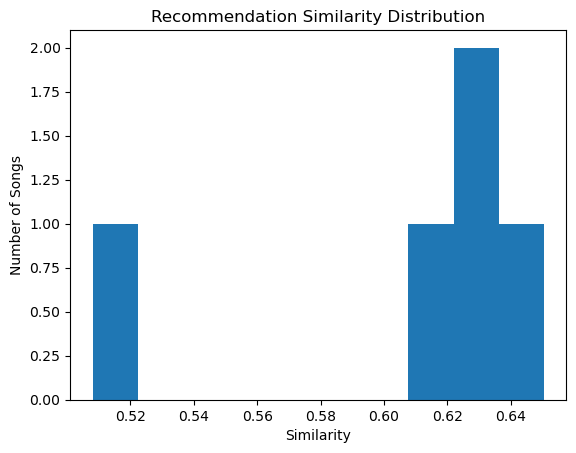

In [ ]:
from pymongo import MongoClient
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity

# -----------------------------
def load_music_data(uri, db_name, collection_name):
    client = MongoClient(uri)
    db = client[db_name]
    collection = db[collection_name]
    data = list(collection.find({}, {"_id": 0}))
    print(f"불러온 곡 개수: {len(data)}")
    return data

# -----------------------------
def make_string(text):
    return " ".join(text) if isinstance(text, list) else str(text)

def make_genres_list(genres):
    if isinstance(genres, list):
        return [g.strip().lower() for g in genres]
    elif isinstance(genres, str):
        return [genres.strip().lower()]
    else:
        return ["unknown"]

# -----------------------------
def train_word2vec(music_data, vector_size=100):
    sentences = []
    for song in music_data:
        lyrics = make_string(song.get("lyrics", "")).lower()
        words = lyrics.split()
        if words:
            sentences.append(words)

    if not sentences:
        raise ValueError('가사 문장이 없음')

    model = Word2Vec(sentences, vector_size=vector_size, window=5, min_count=1, workers=4, epochs=5)
    return model

# -----------------------------
def get_lyrics_vector(lyrics, model):
    words = make_string(lyrics).lower().split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

def get_genre_vector(genres, all_genres):
    onehot = np.zeros(len(all_genres))
    genres_list = make_genres_list(genres)

    for g in genres_list:
        for i, genre_name in enumerate(all_genres):
            if g == genre_name:
                onehot[i] = 1

    return onehot

def make_song_vectors(music_data, model, all_genres):
    vectors = {}
    for song in music_data:
        title = song.get("title", "")
        if not title:
            continue
        lyrics_vec = get_lyrics_vector(song.get("lyrics", ""), model)    # 가사 100차원
        genre_vec = get_genre_vector(song.get("genres", ""), all_genres)  # 장르 10차원
        combined_vec = np.concatenate([lyrics_vec, genre_vec])            # 110차원

        vectors[title] = combined_vec

        print(f"\n[벡터 생성] '{title}'")
        print(f" - 가사 벡터 (lyrics_vec) 일부: {lyrics_vec[:10]} ... (길이: {len(lyrics_vec)})")
        print(f" - 장르 원핫 벡터 (genre_vec): {genre_vec.tolist()} (길이: {len(genre_vec)})")
        print(f" - 결합 벡터 (combined_vec) 일부: {combined_vec[:10]} ... (전체 길이: {len(combined_vec)})")
    return vectors

# -----------------------------
def recommend_songs(target_title, music_data, song_vectors, model_vector_size, top_n=5):
    if target_title not in song_vectors:
        raise ValueError(f"'{target_title}' 곡 벡터가 없습니다.")

    target_vec = song_vectors[target_title]
    print(f"\n[추천 기준 곡] '{target_title}' 벡터 길이: {len(target_vec)}")

    target_lyrics_vec = target_vec[:model_vector_size].reshape(1, -1)
    target_genre_vec = target_vec[model_vector_size:].reshape(1, -1)

    similarities = []

    for song in music_data:
        title = song.get("title", "")
        if not title or title == target_title or title not in song_vectors:
            continue

        compare_vec = song_vectors[title]   # 1D 벡터 (가사+장르) 길이 110
        compare_lyrics_vec = compare_vec[:model_vector_size].reshape(1, -1)  # shape: (1, 100)
        compare_genre_vec  = compare_vec[model_vector_size:].reshape(1, -1)  # shape: (1, 10)
        #여기서 reshape(1, -1)은 벡터를 1행짜리 2D 배열로 변형하는 과정
        #그래서 최종 결과가 이중 리스트 형태인 2D 배열 [[유사도]]이 나옵니다

        lyrics_sim = cosine_similarity(target_lyrics_vec, compare_lyrics_vec)[0][0]
        genre_sim = cosine_similarity(target_genre_vec, compare_genre_vec)[0][0]
        # 이 코드를 통해 이중 리스트 형태인 2D 배열을 float로 꺼내 다른 코사인 유사도 값을 비교한다

        total_sim = (0.4 * lyrics_sim) + (0.6 * genre_sim)

        similarities.append((title, total_sim))

        # 디버깅 출력
        print(f"\n[코사인 유사도 계산] '{target_title}' vs '{title}'")
        print(f" - 비교 벡터 일부(가장 앞부터 5개만 보여지게 만듦)/ 실제로는 다 계산: {compare_vec[:5]}")
        print(f" - 유사도: {total_sim:.4f}")

    similarities.sort(key=lambda x: x[1], reverse=True)
    return similarities[:top_n]

def plot_similarity(similarities):
    scores = [sim for title, sim in similarities]
    plt.hist(scores, bins=10)
    plt.title("Recommendation Similarity Distribution")
    plt.xlabel("Similarity")
    plt.ylabel("Number of Songs")
    plt.show()

# -----------------------------
if __name__ == "__main__":
    uri = "mongodb://localhost:27017/"
    db_name = "music"
    collection_name = "music"

    music_data = load_music_data(uri, db_name, collection_name)

    model = train_word2vec(music_data)

    all_genres_set = set()
    for song in music_data:
        genres = make_genres_list(song.get("genres", ""))
        all_genres_set.update(genres)
    all_genres = sorted(list(all_genres_set))
    print(f"총 장르 수: {len(all_genres)}")

    song_vectors = make_song_vectors(music_data, model, all_genres)

    song_to_recommend = "여행"  # 테스트용
    recommendations = recommend_songs(song_to_recommend, music_data, song_vectors, model.vector_size, top_n=5)

    print(f"\n'{song_to_recommend}'와 비슷한 추천곡 Top {len(recommendations)}:")
    for title, sim in recommendations:
        print(f" - {title} (유사도: {sim:.4f})")

    plot_similarity(recommendations)

왜 100차원인가?

차원의 수가 적으면, 단어 간 복잡한 의미를 표현하기 어렵다.
대신 학습 속도는 빠르다

차원의 수가 크면, 매우 미세한 의미 차이까지 표현이 가능하다
대신 과적합에 걸릴 위험이 크고, 학습 시간/메모리 부담이 크다